In [1]:
from sklearn import datasets
import numpy as np
import pandas as pd
import sklearn
import torch
from torch import nn
from torch.utils.data import DataLoader


from matplotlib import pyplot as plt
plt.rc('figure', max_open_warning = 0)

In [2]:
iris = datasets.load_iris()
X = iris.data  
y = iris.target
X.shape,y.shape

((150, 4), (150,))

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from sklearn.model_selection import train_test_split

data_train,data_test,y_train,y_test = train_test_split(X,y ,random_state=89)
data_train.shape,data_test.shape,y_train.shape,y_test.shape

((112, 4), (38, 4), (112,), (38,))

In [5]:
dataset=[(x,y) for x,y in zip(data_train,y_train)]
data_set=[(x,y) for x,y in zip(data_test,y_test)]

In [6]:
train_loader=DataLoader(dataset, batch_size=8, shuffle=True)
test_loader=DataLoader(data_set,batch_size=19,shuffle=True)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 2)
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)

model=model.double()

learning_rate = 0.001

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate
)

mse=nn.MSELoss()


# Training

In [ ]:
losses=[]

num_epochs=200

batch_size = len(train_loader)


for epoch in range(num_epochs):
    
    X=[]
    Y=[]
    
    total_loss = 0
    
    for data in train_loader:
        
        x,y=data


        output = model(x)  
        e=model.encoder(x).detach().numpy()
                
        X.append(e)
        Y.append(y.numpy())
        
        

        
    
        loss = mse(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.data
        
    total_loss = total_loss / batch_size
    losses.append(total_loss)
    
    Y=np.asarray(Y).reshape(1,-1)
    X=np.asarray(X).reshape(112,2)    
    
    
    print("epoch : {}/{},  loss = {:.4f}".format(epoch + 1, num_epochs, total_loss))
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.scatter(X[:,0], X[:,1],c=Y,s=50)
    ax.set_title('epoch {}'.format(epoch+1))
    plt.savefig('iris_ae{}.png'.format(epoch+1), dpi = 300)

# Visualization of loss function

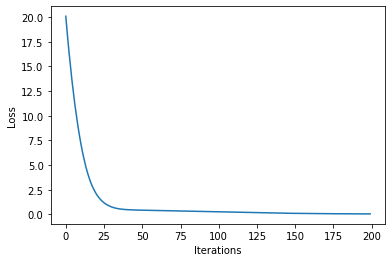

In [9]:
plt.plot(losses[:])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# Test

====> Test set loss: 0.0572


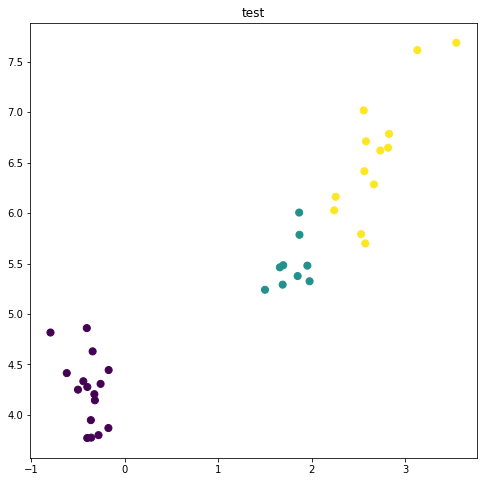

In [10]:
test_loss = 0
s=0
with torch.no_grad():
    X=[]
    Y=[]

    for data in test_loader:
        x,y=data

        output = model(x)


            
        
        e=model.encoder(x).detach().numpy()
                
        X.append(e)
        
        Y.append(y.numpy())
        

        
    
        loss = mse(output, x)
        test_loss += loss.item()
        
    test_loss /= len(test_loader)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    
    Y=np.asarray(Y).reshape(1,-1)
    X=np.asarray(X).reshape(38,2)  
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    ax.scatter(X[:,0], X[:,1],c=Y,s=50)
    ax.set_title('test')

# Visualization of latent space

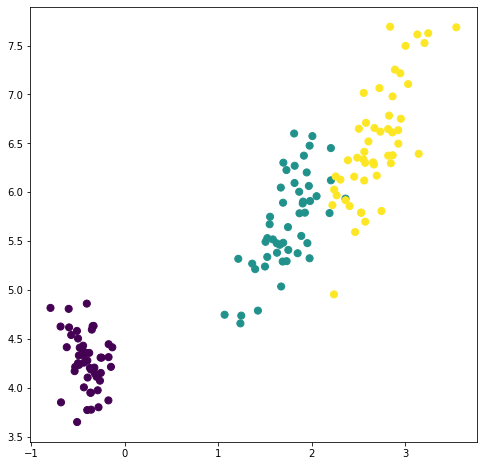

In [11]:
X = iris.data  
y = iris.target
m=model.encoder(torch.from_numpy(X))
fig = plt.figure(figsize=(8,8))
ax = plt.axes()
ax.scatter(m[:,0].detach().numpy(), m[:,1].detach().numpy(),c=y,s=50)

# Evaluation

In [12]:
import math
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing

In [13]:
def matrice_distance(data):
    d=euclidean_distances(data,data)
    d=preprocessing.normalize(d)
    return d

In [14]:
m=m.detach().numpy()
A=matrice_distance(m)
B=d=matrice_distance(X)

In [15]:
def estimateur(data,d,sigma):
    f=[]
    for i in range(40):
        s=0
        for j in range(40):
            s=s+math.exp(- (d[i][j]**2)*(sigma**(-1)))
        f.append(s)
    return f

In [16]:
sigma=[0.01,0.1,1]

f=[estimateur(X,B,sigma) for sigma in sigma]

g=[estimateur(m,A,sigma) for sigma in sigma] 

In [17]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float64)
    b = np.asarray(b, dtype=np.float64)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [18]:
kl=[]
for i in range(3):
    kl.append(KL(f[i],g[i]))

In [19]:
RMSE=[]

MSE = np.square(np.subtract(B,A)).mean()

RMSE.append(math.sqrt(MSE))

In [20]:
from sklearn.manifold import trustworthiness

Trust=[]

Trust.append(sklearn.manifold.trustworthiness(B,A))

In [21]:
from sklearn.metrics import mean_squared_error
mse=[]
mse.append(mean_squared_error(X,model(torch.from_numpy(X)).detach().numpy()))

In [22]:
Tab=pd.DataFrame([kl])
Tab.columns=['KL_0.01','KL_0.1','KL_1']
Tab['RMSE']=RMSE
Tab['Trust']=Trust
Tab['MSE']=mse
Tab

,KL_0.01,KL_0.1,KL_1,RMSE,Trust,MSE
0,-22.151358,-2.335296,-0.234788,0.004778,0.98031,0.050925
